In [1]:
import pandas as pd
import numpy as np

# Load news data
news_cols = ["newsID", "category", "subcategory", "title", "abstract", "url", "title_entities", "abstract_entities"]
news_df = pd.read_csv("train_data/news.tsv", sep="\t", header=None, names=news_cols)

In [3]:
# Check for duplicates
duplicate_news = news_df.duplicated(subset=["newsID"]).sum()
print(f"Duplicate news IDs: {duplicate_news}")

Duplicate news IDs: 0


In [4]:
# Check unique titles
duplicate_titles = news_df[news_df.duplicated(subset=["title"], keep=False)]
print(f"Duplicate news titles: {len(duplicate_titles)}")

Duplicate news titles: 5367


In [10]:
# How many unique titles collide?
title_counts = news_df['title'].value_counts()
dupe_title_groups = title_counts[title_counts > 1]
print(f"{len(dupe_title_groups)} unique titles repeated")

2228 unique titles repeated


In [5]:
# Missing values
print("\nMissing values in news data:")
print(news_df.isnull().sum())
print(f"Percentage of abstracts missing: {news_df['abstract'].isnull().mean()*100:.2f}%")


Missing values in news data:
newsID                  0
category                0
subcategory             0
title                   0
abstract             5415
url                     0
title_entities          3
abstract_entities       6
dtype: int64
Percentage of abstracts missing: 5.33%


In [11]:
# Replace missing abstracts with an empty string
news_df['abstract'] = news_df['abstract'].fillna("")

In [13]:
news_df['title_entities']    = news_df['title_entities'].fillna("[]")
news_df['abstract_entities'] = news_df['abstract_entities'].fillna("[]")

In [14]:
# Missing values
print("\nMissing values in news data:")
print(news_df.isnull().sum())
print(f"Percentage of abstracts missing: {news_df['abstract'].isnull().mean()*100:.2f}%")


Missing values in news data:
newsID               0
category             0
subcategory          0
title                0
abstract             0
url                  0
title_entities       0
abstract_entities    0
title_length         0
abstract_length      0
dtype: int64
Percentage of abstracts missing: 0.00%


In [2]:
news_df.value_counts()

newsID   category       subcategory        title                                                                                       abstract                                                                                                                                                                                                                                                                                                                                                                                                        url                                            title_entities                                                                                                                                                                                                                                                                                                                                                                                                                    

In [15]:
# Check title and abstract lengths
news_df["title_length"] = news_df["title"].str.len()
news_df["abstract_length"] = news_df["abstract"].fillna("").str.len()
# Identify very short titles/abstracts (potential quality issues)
print(f"\nVery short titles (<10 chars): {(news_df['title_length'] < 10).sum()}")
print(f"Very short abstracts (<20 chars): {(news_df['abstract_length'] < 20).sum()}")


Very short titles (<10 chars): 0
Very short abstracts (<20 chars): 6035


In [8]:
# Examine category distribution
category_counts = news_df["category"].value_counts()
print("\nCategory distribution:")
print(category_counts)

# Potential adjustments based on exploration:
# 1. Filter out articles with missing abstracts if needed
# 2. Set minimum length requirements for titles and abstracts
# 3. Balance categories if severely imbalanced


Category distribution:
category
sports           32020
news             30478
finance           5916
travel            4955
lifestyle         4570
video             4569
foodanddrink      4418
weather           4255
autos             3071
health            2929
tv                1323
music             1263
entertainment      837
movies             815
kids               104
middleeast           2
games                1
northamerica         1
Name: count, dtype: int64


                    ctr                
                   mean       std count
category                               
kids           0.107143  0.196699     7
sports         0.059902  0.195459  2169
travel         0.044095  0.170356   480
news           0.041533  0.142608  2838
lifestyle      0.036431  0.130621   623
autos          0.036013  0.144523   376
tv             0.034387  0.063452   160
weather        0.032610  0.134904   441
video          0.032591  0.091652   348
health         0.030780  0.116116   509
foodanddrink   0.029290  0.098171   541
music          0.029224  0.072790   178
movies         0.026706  0.100142   135
entertainment  0.026439  0.081222   154
finance        0.023831  0.088178   642
northamerica   0.000000       NaN     1

ANOVA: F=4.5567, p=0.000000
Significant differences:


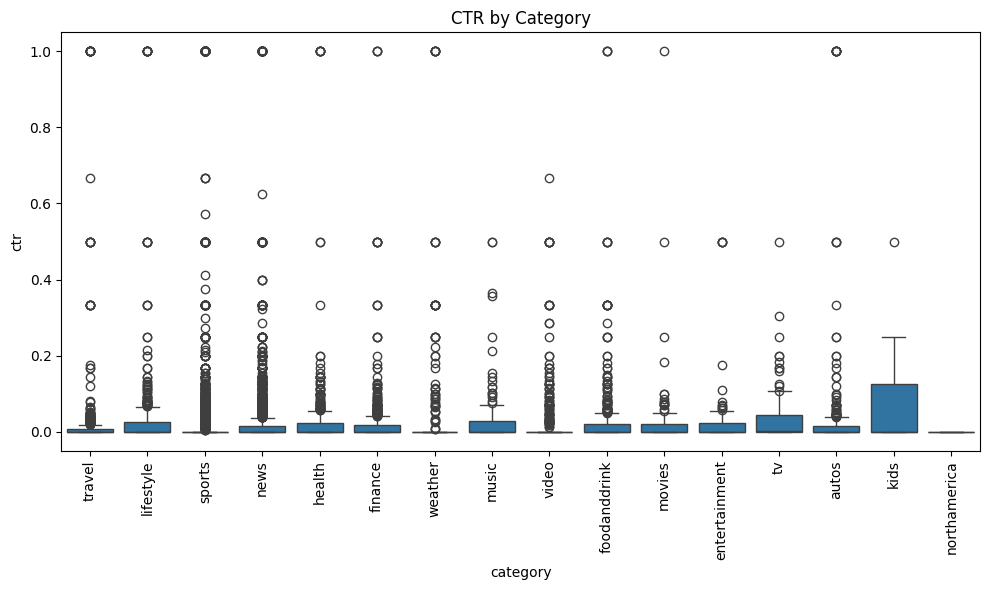

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load limited sample of data
news_cols = ["newsID", "category", "subcategory", "title", "abstract", "url", "title_entities", "abstract_entities"]
news_df = pd.read_csv("train_data/news.tsv", sep="\t", header=None, names=news_cols)

# Sample just first 10,000 behaviors (adjust as needed)
behaviors_cols = ["impression_id", "user_id", "time", "history", "impressions"]
behaviors_df = pd.read_csv("train_data/behaviors.tsv", sep="\t", header=None, 
                         names=behaviors_cols, nrows=10000)

# Process impressions
impression_records = []
for _, row in behaviors_df.iterrows():
    for item in row['impressions'].split():
        parts = item.split('-')
        if len(parts) == 2:
            news_id, click = parts
            impression_records.append({
                'news_id': news_id,
                'clicked': int(click)
            })

# Calculate CTR
impressions_df = pd.DataFrame(impression_records)
article_ctr = impressions_df.groupby('news_id').agg({
    'clicked': ['sum', 'count']
})
article_ctr.columns = ['clicks', 'impressions']
article_ctr['ctr'] = article_ctr['clicks'] / article_ctr['impressions']

# Merge with news categories
article_ctr = article_ctr.reset_index()
merged_df = article_ctr.merge(news_df[['newsID', 'category']], 
                             left_on='news_id', right_on='newsID',
                             how='inner')

# Show CTR by category
category_stats = merged_df.groupby('category').agg({
    'ctr': ['mean', 'std', 'count']
})
print(category_stats.sort_values(('ctr', 'mean'), ascending=False))

# Create visual
plt.figure(figsize=(10, 6))
sns.boxplot(x='category', y='ctr', data=merged_df)
plt.xticks(rotation=90)
plt.title('CTR by Category')
plt.tight_layout()
plt.savefig('category_ctr_boxplot.png')

# One-way ANOVA test
categories = []
ctr_values = []
for category, group in merged_df.groupby('category'):
    if len(group) >= 30:
        categories.append(category)
        ctr_values.append(group['ctr'].values)

if len(categories) >= 2:
    f_stat, p_value = stats.f_oneway(*ctr_values)
    print(f"\nANOVA: F={f_stat:.4f}, p={p_value:.6f}")
    print("Significant differences:" if p_value < 0.05 else "No significant differences:")

CTR varies significantly by category (ANOVA p < 0.001), with higher engagement observed in 'kids', 'sports', and 'travel'. Although this insight could be used to weight or balance editorial attention—such as focusing headline optimization on low-CTR categories—this step was not implemented in the current version. Future iterations could incorporate this for better content diversity or targeted performance tuning.

In [3]:
# Save as a pickle file
news_df.to_pickle("cleaned_news.pkl")